In [6]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from src.connectivity_functions import *
from src.tree_functions import *
from src.ni_functions import *
from src.io_functions import load_data, load_receptor_data
import os
import json
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 25)
import seaborn as sns

/usr/local/lib/python3.9/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")
/usr/local/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [3]:
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc")
    )
    fc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc")
    )
    fcm, scm = connectome_average(fc_group, sc_group)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


In [4]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (
    len(scm_nonzero.flatten())
)
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(
    zero_rows_fc, fcm_thr, scm_nonzero
)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0)

print("connectome density = " + str(density))

connectome density = 0.07191603968863612


In [5]:
initial_parcellation = nib.load(os.path.join(
        project_path,
        "data",
        "results",
        "n" + str(conn_size),
        "initial_partition.nii.gz",
    ))
initial_parcellation_data = initial_parcellation.get_fdata()

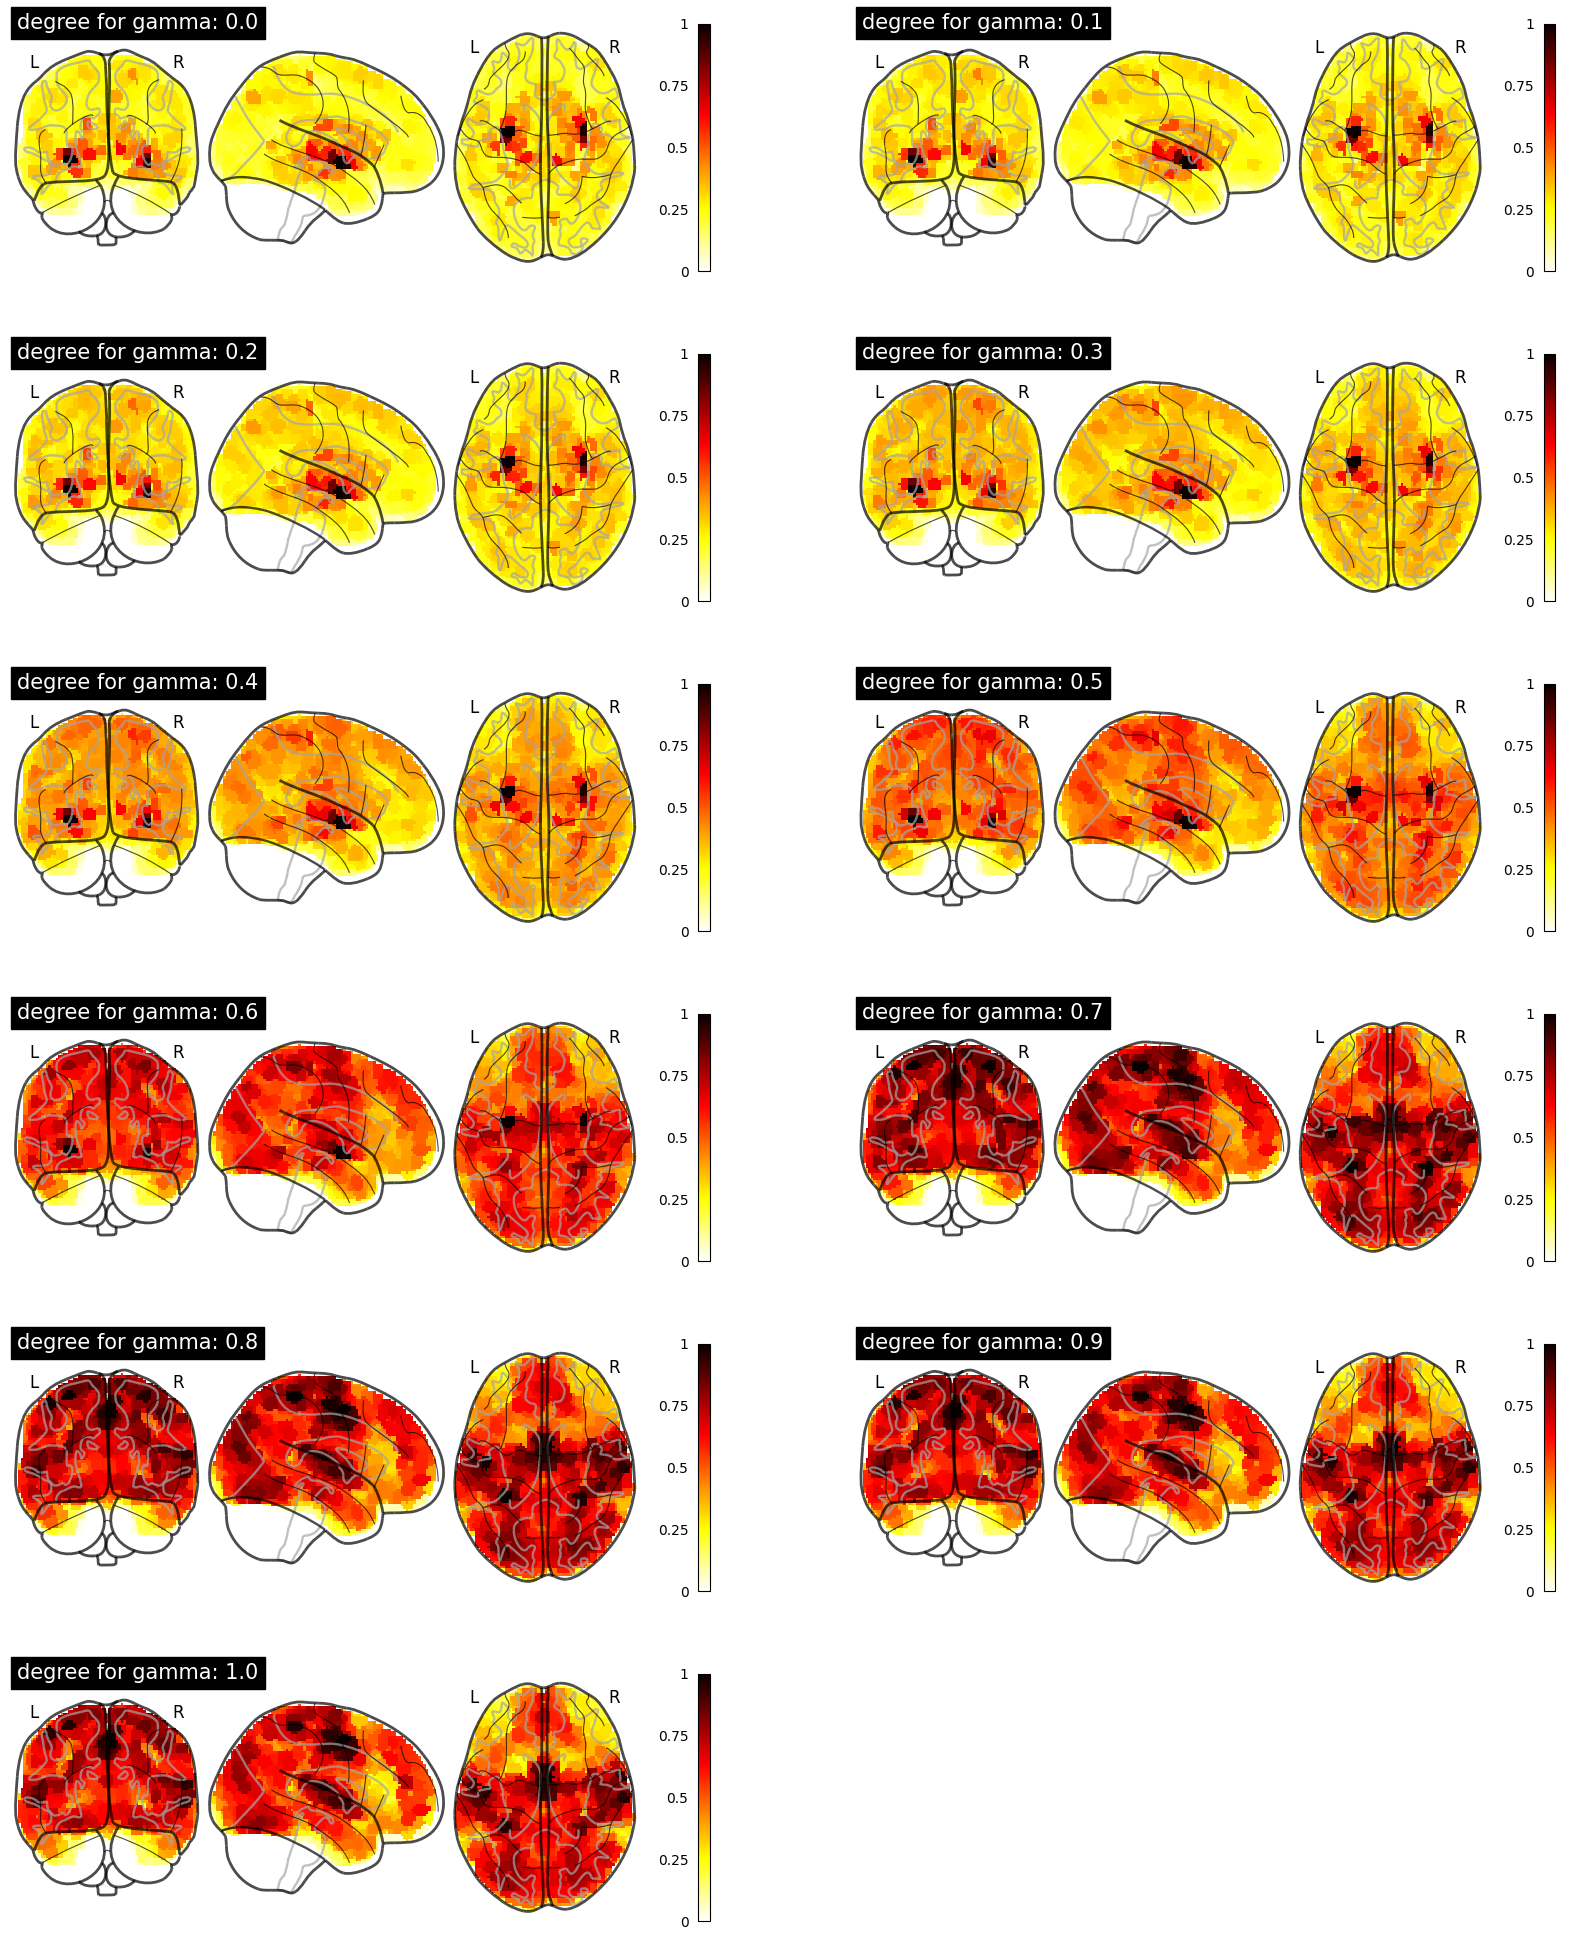

In [6]:
fig = plt.figure()

gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for idx, g in enumerate(gammas_vec):
    ax = fig.add_subplot(6, 2, idx + 1)
    cc = abs(((g * abs(fcm_bin)) + ((1 - g) * scm_bin)))
    strength_fullmat = cc.sum(axis=0, dtype=float)
    deg_img = np.zeros(initial_parcellation_data.shape)
    for roi in range(len(strength_fullmat)):
        deg_img[initial_parcellation_data == roi + 1] = strength_fullmat[roi] / np.max(strength_fullmat)

    plotting.plot_glass_brain(
        nib.Nifti1Image(deg_img, affine=initial_parcellation.affine),
        colorbar=True,
        title="degree for gamma: " + str(g),
        axes=ax,
    )
    plt.savefig(
        os.path.join(project_path, "data", "results", "figures", "gamma_degrees_brain.svg"),
        dpi=300,
        bbox_inches="tight",
        format="svg",
    )
    nib.save(
        nib.Nifti1Image(deg_img, affine=initial_parcellation.affine),
        os.path.join(
            project_path,
            "data",
            "results",
            "n" + str(conn_size),
            "degree_g_" + str(g) + ".nii.gz",
        ),
    )

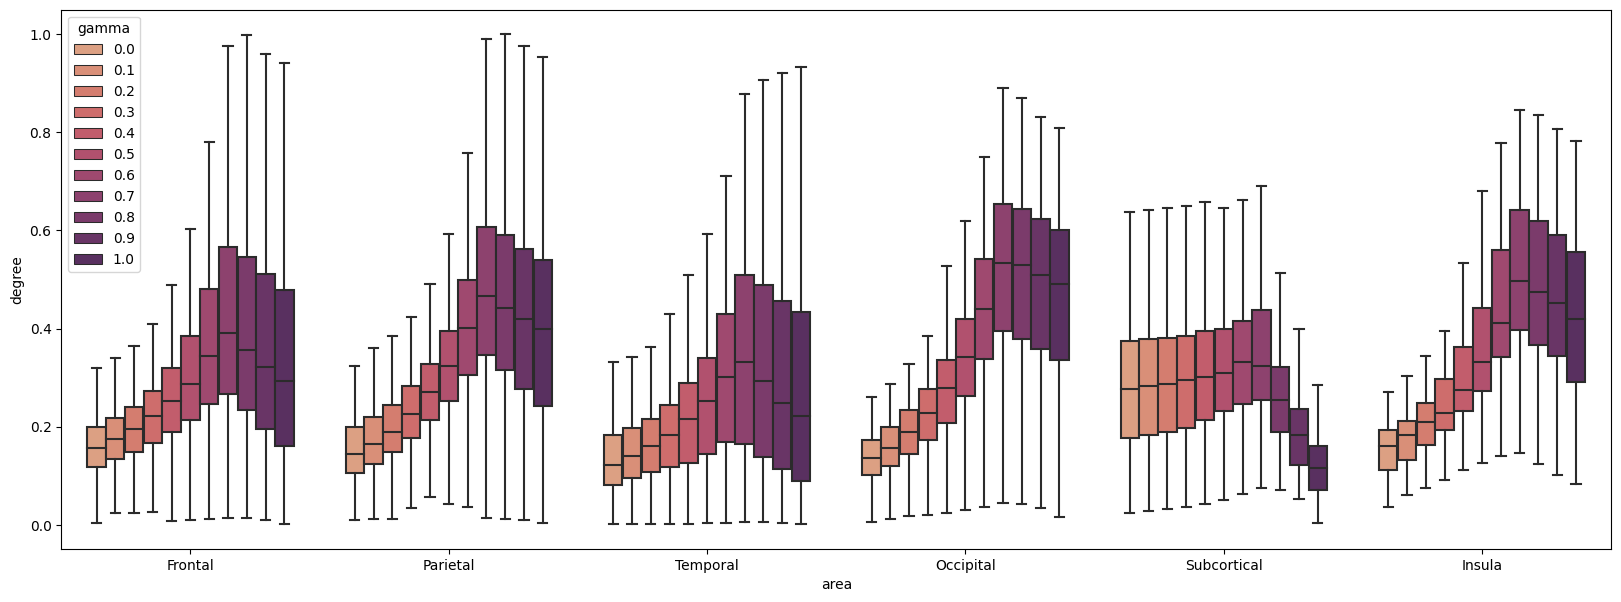

In [7]:
gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
lobe_list = ["Frontal", "Parietal", "Temporal", "Occipital", "Subcortical", "Insula"]

strength_vals = []
area_name = []
gamma_val = []
for lobe in lobe_list:
    lobe_mask = nib.load(
        os.path.join(
            project_path, "brain_templates", "lobule_masks", lobe + "_mask.nii.gz"
        )
    )
    lobe_rois = get_atlas_rois_from_mask(lobe_mask, initial_parcellation)
    for g in gammas_vec:
        cc = abs(((g * abs(fcm_bin)) + ((1 - g) * scm_bin)))
        strength_fullmat = cc.sum(axis=0, dtype=float)
        for roi in lobe_rois:
            strength_vals.append(
                strength_fullmat[int(roi) - 1] / np.max(strength_fullmat)
            )
            area_name.append(lobe)
            gamma_val.append(g)

plt.rcParams["figure.figsize"] = [20, 7]
fig = plt.figure()
df = pd.DataFrame({"degree": strength_vals, "area": area_name, "gamma": gamma_val})
sns.boxplot(x="area", y="degree", hue="gamma", data=df, showfliers=False, palette="flare")
plt.savefig(
        os.path.join(project_path, "data", "results", "figures", "gamma_degrees_lobules.svg"),
        dpi=300,
        bbox_inches="tight",
        format="svg",
    )